In [1]:
pip install -q tensorflow==2.20.0 opencv-python-headless==4.10.0.84 scikit-learn pillow matplotlib gradio torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cpu

Note: you may need to restart the kernel to use updated packages.


In [2]:
# Imports & constants
import os
import random
from glob import glob
from PIL import Image, ImageOps, ImageFilter
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as T
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
import joblib
import gradio as gr

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

DATA_ROOT = r"C:\Users\prajw\Desktop\biometric_data"   # your uploaded dataset path
IMG_SIZE = 128  # size for model inputs
BATCH_SIZE = 16
NUM_EPOCHS = 15
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", DEVICE)

Device: cpu


In [3]:
def collect_images(root):
    iris_root = os.path.join(root, "iris")
    fp_root = os.path.join(root, "fingerprint")
    iris_classes = sorted([d for d in os.listdir(iris_root) if os.path.isdir(os.path.join(iris_root,d))])
    fp_classes = sorted([d for d in os.listdir(fp_root) if os.path.isdir(os.path.join(fp_root,d))])
    data = {"iris":{}, "fingerprint":{}}
    for c in iris_classes:
        data["iris"][c] = sorted(glob(os.path.join(iris_root, c, "*")))
    for c in fp_classes:
        data["fingerprint"][c] = sorted(glob(os.path.join(fp_root, c, "*")))
    return data

data_index = collect_images(DATA_ROOT)
print("Iris classes:", list(data_index["iris"].keys()))
print("Fingerprint classes:", list(data_index["fingerprint"].keys()))

Iris classes: ['A', 'B', 'C', 'D']
Fingerprint classes: ['A', 'B', 'C', 'D']


In [4]:
def open_rgb(path):
    img = Image.open(path).convert("RGB")
    return img

def resize_square(img, size=IMG_SIZE):
    return ImageOps.fit(img, (size, size), Image.Resampling.LANCZOS)

def rubik_permute(img, tiles=8):
    """
    Simple deterministic 'Rubik-like' tile permutation:
    - split img into tiles x tiles grid, shuffle tiles with a fixed permutation
    """
    w, h = img.size
    assert w == h
    t = tiles
    tile_w = w // t
    tile_h = h // t
    tiles_list = []
    for i in range(t):
        for j in range(t):
            box = (j*tile_w, i*tile_h, (j+1)*tile_w, (i+1)*tile_h)
            tiles_list.append(img.crop(box))
    
    rng = np.random.RandomState(12345)
    perm = rng.permutation(len(tiles_list))
    new_img = Image.new('RGB', (w,h))
    idx = 0
    for i in range(t):
        for j in range(t):
            tile = tiles_list[perm[idx]]
            new_img.paste(tile, (j*tile_w, i*tile_h))
            idx += 1
    return new_img

def blend_watermark(iris_img, fp_img, alpha=0.5):
    
    return Image.blend(iris_img, fp_img, alpha=alpha)

In [5]:
samples = []
labels = []

iris_index = data_index["iris"]
fp_index = data_index["fingerprint"]

for cls in iris_index:
    iris_files = iris_index[cls]
    
    fp_files = fp_index.get(cls, [])
    if not fp_files:
        
        fp_files = next(iter(fp_index.values()))
   
    for i in range(min(len(iris_files), len(fp_files))):
        iris = resize_square(open_rgb(iris_files[i]))
        fp_perm = rubik_permute(resize_square(open_rgb(fp_files[i])))
        wm = blend_watermark(iris, fp_perm, alpha=0.5)
        samples.append(wm)
        labels.append(1)  # genuine


num_to_generate = len(samples)
all_fp_paths = [p for paths in fp_index.values() for p in paths]
all_iris_paths = [p for paths in iris_index.values() for p in paths]

def distort(img):
    
    if random.random() < 0.5:
        img = img.filter(ImageFilter.GaussianBlur(radius=random.uniform(0.5,2.0)))
    if random.random() < 0.5:
        img = img.rotate(random.uniform(-20,20))
    if random.random() < 0.5:
        arr = np.array(img).astype(np.float32)
        noise = np.random.normal(0,10,arr.shape)
        arr = np.clip(arr + noise, 0, 255).astype(np.uint8)
        img = Image.fromarray(arr)
    return img

for _ in range(num_to_generate):
    iris = resize_square(open_rgb(random.choice(all_iris_paths)))
    fp_wrong = resize_square(open_rgb(random.choice(all_fp_paths)))
    fp_wrong = rubik_permute(fp_wrong)
    # add distortion to fingerprint or iris
    if random.random() < 0.6:
        fp_wrong = distort(fp_wrong)
    else:
        iris = distort(iris)
    wm = blend_watermark(iris, fp_wrong, alpha=random.uniform(0.3,0.7))
    samples.append(wm)
    labels.append(0)  # forged

print("Total samples:", len(samples), "Genuine:", sum(labels), "Forged:", len(labels)-sum(labels))

Total samples: 80 Genuine: 40 Forged: 40


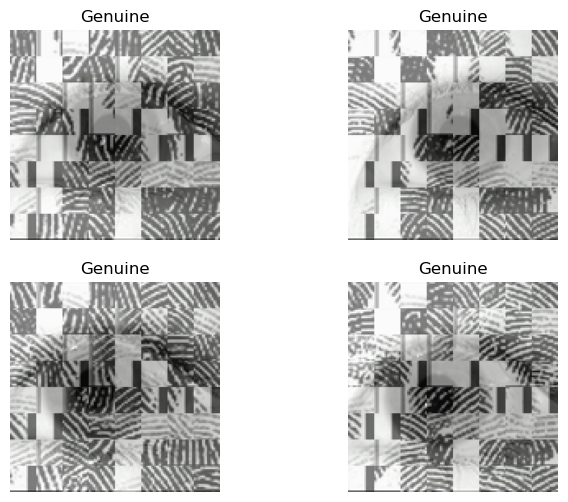

In [6]:
plt.figure(figsize=(8,6))
for i in range(4):
    plt.subplot(2,2,i+1)
    plt.imshow(samples[i])
    plt.title("Genuine" if labels[i]==1 else "Forged")
    plt.axis('off')
plt.show()

In [7]:
# PyTorch Dataset & transforms
class WatermarkDataset(Dataset):
    def __init__(self, pil_images, labels, transform=None):
        self.images = pil_images
        self.labels = labels
        self.transform = transform
    def __len__(self):
        return len(self.images)
    def __getitem__(self, idx):
        img = self.images[idx]
        label = self.labels[idx]
        if self.transform:
            img = self.transform(img)
        return img, torch.tensor(label, dtype=torch.long)

transform = T.Compose([
    T.Resize((IMG_SIZE, IMG_SIZE)),
    T.ToTensor(),
    T.Normalize([0.5,0.5,0.5], [0.5,0.5,0.5])
])


from sklearn.model_selection import train_test_split
train_imgs, temp_imgs, train_labels, temp_labels = train_test_split(samples, labels, test_size=0.3, random_state=SEED, stratify=labels)
val_imgs, test_imgs, val_labels, test_labels = train_test_split(temp_imgs, temp_labels, test_size=0.5, random_state=SEED, stratify=temp_labels)

train_ds = WatermarkDataset(train_imgs, train_labels, transform=transform)
val_ds = WatermarkDataset(val_imgs, val_labels, transform=transform)
test_ds = WatermarkDataset(test_imgs, test_labels, transform=transform)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)
test_loader = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

print("Train/Val/Test sizes:", len(train_ds), len(val_ds), len(test_ds))

Train/Val/Test sizes: 56 12 12


In [8]:
# simple CNN model
class SimpleCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(32, 64, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(64, 128, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(128, 256, 3, padding=1), nn.ReLU(), nn.AdaptiveAvgPool2d((4,4))
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(256*4*4, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 2)
        )
    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

model = SimpleCNN().to(DEVICE)
print(model)

SimpleCNN(
  (features): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (10): ReLU()
    (11): AdaptiveAvgPool2d(output_size=(4, 4))
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=4096, out_features=256, bias=True)
    (2): ReLU()
    (3): Dropout(p=0.3, inplace=False)
    (4): Linear(in_features=256, out_features=2, bias=True)
  )
)


In [9]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=3, factor=0.5)

def evaluate(loader, model):
    model.eval()
    preds = []
    targets = []
    losses = []
    with torch.no_grad():
        for xb, yb in loader:
            xb = xb.to(DEVICE)
            yb = yb.to(DEVICE)
            out = model(xb)
            loss = criterion(out, yb)
            losses.append(loss.item())
            ps = torch.softmax(out, dim=1)[:,1].cpu().numpy()
            pcls = np.argmax(out.detach().cpu().numpy(), axis=1)
            preds.extend(pcls.tolist())
            targets.extend(yb.cpu().numpy().tolist())
    avg_loss = np.mean(losses) if losses else 0
    acc = accuracy_score(targets, preds)
    prec = precision_score(targets, preds, zero_division=0)
    rec = recall_score(targets, preds, zero_division=0)
    f1 = f1_score(targets, preds, zero_division=0)
    return avg_loss, acc, prec, rec, f1, preds, targets

In [10]:
best_val_loss = float('inf')
for epoch in range(1, NUM_EPOCHS+1):
    model.train()
    running_loss = 0.0
    for xb, yb in tqdm(train_loader, desc=f"Epoch {epoch}/{NUM_EPOCHS}"):
        xb = xb.to(DEVICE)
        yb = yb.to(DEVICE)
        optimizer.zero_grad()
        out = model(xb)
        loss = criterion(out, yb)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * xb.size(0)
    train_loss = running_loss / len(train_loader.dataset)

    val_loss, val_acc, val_prec, val_rec, val_f1, _, _ = evaluate(val_loader, model)
    scheduler.step(val_loss)
    print(f"\nEpoch {epoch} Train loss: {train_loss:.4f} | Val loss: {val_loss:.4f} | Acc: {val_acc:.4f} | Prec: {val_prec:.4f} | Rec: {val_rec:.4f} | F1: {val_f1:.4f}")

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), r"C:\Users\prajw\Desktop\VeriMark_AI\watermark_cnn_best.pth")
        print("Saved best model.")

Epoch 1/15: 100%|████████████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.64it/s]



Epoch 1 Train loss: 0.7274 | Val loss: 0.6930 | Acc: 0.5000 | Prec: 0.5000 | Rec: 1.0000 | F1: 0.6667
Saved best model.


Epoch 2/15: 100%|████████████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.15it/s]



Epoch 2 Train loss: 0.6926 | Val loss: 0.6930 | Acc: 0.5000 | Prec: 0.0000 | Rec: 0.0000 | F1: 0.0000
Saved best model.


Epoch 3/15: 100%|████████████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.17it/s]



Epoch 3 Train loss: 0.6928 | Val loss: 0.6929 | Acc: 0.5000 | Prec: 0.0000 | Rec: 0.0000 | F1: 0.0000
Saved best model.


Epoch 4/15: 100%|████████████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.20it/s]



Epoch 4 Train loss: 0.6926 | Val loss: 0.6925 | Acc: 0.5000 | Prec: 0.0000 | Rec: 0.0000 | F1: 0.0000
Saved best model.


Epoch 5/15: 100%|████████████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.42it/s]



Epoch 5 Train loss: 0.6865 | Val loss: 0.6905 | Acc: 0.5000 | Prec: 0.0000 | Rec: 0.0000 | F1: 0.0000
Saved best model.


Epoch 6/15: 100%|████████████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.38it/s]



Epoch 6 Train loss: 0.6894 | Val loss: 0.6922 | Acc: 0.5833 | Prec: 0.5455 | Rec: 1.0000 | F1: 0.7059


Epoch 7/15: 100%|████████████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.35it/s]



Epoch 7 Train loss: 0.6651 | Val loss: 0.6884 | Acc: 0.5000 | Prec: 0.0000 | Rec: 0.0000 | F1: 0.0000
Saved best model.


Epoch 8/15: 100%|████████████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.24it/s]



Epoch 8 Train loss: 0.6375 | Val loss: 0.6916 | Acc: 0.5833 | Prec: 0.5455 | Rec: 1.0000 | F1: 0.7059


Epoch 9/15: 100%|████████████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.38it/s]



Epoch 9 Train loss: 0.6206 | Val loss: 0.6866 | Acc: 0.5833 | Prec: 0.5455 | Rec: 1.0000 | F1: 0.7059
Saved best model.


Epoch 10/15: 100%|███████████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.42it/s]



Epoch 10 Train loss: 0.5706 | Val loss: 0.6917 | Acc: 0.5000 | Prec: 0.5000 | Rec: 1.0000 | F1: 0.6667


Epoch 11/15: 100%|███████████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.39it/s]



Epoch 11 Train loss: 0.5447 | Val loss: 0.6615 | Acc: 0.6667 | Prec: 0.6000 | Rec: 1.0000 | F1: 0.7500
Saved best model.


Epoch 12/15: 100%|███████████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.41it/s]



Epoch 12 Train loss: 0.4753 | Val loss: 0.6104 | Acc: 0.7500 | Prec: 0.6667 | Rec: 1.0000 | F1: 0.8000
Saved best model.


Epoch 13/15: 100%|███████████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.34it/s]



Epoch 13 Train loss: 0.4328 | Val loss: 0.6932 | Acc: 0.6667 | Prec: 0.6000 | Rec: 1.0000 | F1: 0.7500


Epoch 14/15: 100%|███████████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.55it/s]



Epoch 14 Train loss: 0.4614 | Val loss: 0.7084 | Acc: 0.6667 | Prec: 0.6000 | Rec: 1.0000 | F1: 0.7500


Epoch 15/15: 100%|███████████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.43it/s]


Epoch 15 Train loss: 0.4671 | Val loss: 0.8599 | Acc: 0.5000 | Prec: 0.5000 | Rec: 1.0000 | F1: 0.6667


In [11]:
model.load_state_dict(torch.load( r"C:\Users\prajw\Desktop\VeriMark_AI\watermark_cnn_best.pth", map_location=DEVICE))
test_loss, test_acc, test_prec, test_rec, test_f1, test_preds, test_targets = evaluate(test_loader, model)
print("Test results:")
print(f"Loss: {test_loss:.4f}, Acc: {test_acc:.4f}, Prec: {test_prec:.4f}, Rec: {test_rec:.4f}, F1: {test_f1:.4f}")
print("\nClassification report:")
print(classification_report(test_targets, test_preds, target_names=["Forged","Genuine"]))
cm = confusion_matrix(test_targets, test_preds)
print("Confusion matrix:\n", cm)

Test results:
Loss: 0.5581, Acc: 0.6667, Prec: 0.6250, Rec: 0.8333, F1: 0.7143

Classification report:
              precision    recall  f1-score   support

      Forged       0.75      0.50      0.60         6
     Genuine       0.62      0.83      0.71         6

    accuracy                           0.67        12
   macro avg       0.69      0.67      0.66        12
weighted avg       0.69      0.67      0.66        12

Confusion matrix:
 [[3 3]
 [1 5]]


In [12]:
import os

save_dir = r"Bio"

os.makedirs(save_dir, exist_ok=True)

joblib.dump({
    "img_size": IMG_SIZE
}, os.path.join(save_dir, "watermark_metadata.joblib"))

print(f"Artifacts saved to: {save_dir}")

Artifacts saved to: Bio


In [13]:
from torchvision.transforms.functional import to_pil_image

def prepare_watermark_from_paths(iris_path, fp_path, alpha=0.5):
    iris = resize_square(open_rgb(iris_path))
    fp = resize_square(open_rgb(fp_path))
    fp = rubik_permute(fp)
    wm = blend_watermark(iris, fp, alpha=alpha)
    return wm

def pil_to_tensor(img):
    t = transform(img).unsqueeze(0).to(DEVICE)
    return t

def predict_watermark(pil_img):
    model.eval()
    t = transform(pil_img).unsqueeze(0).to(DEVICE)
    with torch.no_grad():
        out = model(t)
        probs = torch.softmax(out, dim=1).cpu().numpy()[0]
        pred = int(np.argmax(probs))
    # pred: 0 forged, 1 genuine
    return pred, float(probs[pred]), probs.tolist()

In [14]:
pip install cryptography

Defaulting to user installation because normal site-packages is not writeableNote: you may need to restart the kernel to use updated packages.



In [15]:
import gradio as gr
import torch
import hashlib
import json
from cryptography.fernet import Fernet
from PIL import Image
import os

def compute_watermark_hash(iris_path, fp_path):
    iris_p = Image.open(iris_path).convert("RGB")
    fp_p = Image.open(fp_path).convert("RGB")
    iris_p = resize_square(iris_p)
    fp_p = resize_square(fp_p)
    fp_p = rubik_permute(fp_p)
    wm = blend_watermark(iris_p, fp_p, alpha=0.5)
    pred, conf, probs = predict_watermark(wm)
    if pred != 1:
        return None, wm
    wm_bytes = wm.tobytes()
    wm_hash = hashlib.sha256(wm_bytes).hexdigest()
    return wm_hash, wm


# ------------------- Security Functions -------------------

KEY_FILE = "biometric_keys.json"
SECURE_FOLDER = "secure_files"
os.makedirs(SECURE_FOLDER, exist_ok=True)

def load_keys():
    if os.path.exists(KEY_FILE):
        with open(KEY_FILE, "r") as f:
            return json.load(f)
    return {}

def save_keys(keys):
    with open(KEY_FILE, "w") as f:
        json.dump(keys, f, indent=4)

def encrypt_file(file_path, key):
    with open(file_path, "rb") as f:
        data = f.read()
    fernet = Fernet(key)
    encrypted = fernet.encrypt(data)
    enc_path = os.path.join(SECURE_FOLDER, os.path.basename(file_path) + ".enc")
    with open(enc_path, "wb") as ef:
        ef.write(encrypted)
    return enc_path

def decrypt_file(enc_path, key):
    with open(enc_path, "rb") as ef:
        encrypted = ef.read()
    fernet = Fernet(key)
    decrypted = fernet.decrypt(encrypted)
    base = os.path.basename(enc_path)
    if base.endswith(".enc"):
        base = base[:-4]
    dec_path = os.path.join(SECURE_FOLDER, f"decrypted_{base}")
    with open(dec_path, "wb") as df:
        df.write(decrypted)
    return dec_path


# ------------------- Registration -------------------

def register_file(file, iris_img, fp_img):
    if not file or not iris_img or not fp_img:
        return "Please upload all required files.", None, gr.update(visible=False)
    wm_hash, wm = compute_watermark_hash(iris_img, fp_img)
    if wm_hash is None:
        return "Biometric verification failed. Cannot secure file.", None, gr.update(visible=False)
    key = Fernet.generate_key()
    encrypted_path = encrypt_file(file.name, key)
    keys = load_keys()
    keys[wm_hash] = key.decode()
    save_keys(keys)
    # Popup-style notification message
    return f"File secured successfully → {os.path.basename(encrypted_path)}", wm, gr.update(value="Encryption successful!", visible=True)


# ------------------- Access (Text & Image Only) -------------------

def access_file(enc_file, iris_img, fp_img):
    if not enc_file or not iris_img or not fp_img:
        return "Please upload all required files.", None, None, None

    wm_hash, wm = compute_watermark_hash(iris_img, fp_img)
    if wm_hash is None:
        return "Access Denied: Biometric not recognized.", wm, None, None

    keys = load_keys()
    if wm_hash not in keys:
        return "Access Denied: Unauthorized user.", wm, None, None

    key = keys[wm_hash].encode()
    dec_path = decrypt_file(enc_file.name, key)
    msg = f"Access Granted: File decrypted successfully → {os.path.basename(dec_path)}"

    file_ext = os.path.splitext(dec_path)[1].lower()
    text_content, img_content = None, None

    try:
        if file_ext in [".txt", ".csv", ".json", ".log"]:
            with open(dec_path, "r", encoding="utf-8", errors="ignore") as f:
                text_content = f.read()
        elif file_ext in [".png", ".jpg", ".jpeg"]:
            img = Image.open(dec_path)
            img.thumbnail((400, 400))
            img_content = img
        else:
            msg += "\n File type not viewable here — check your folder."
    except Exception as e:
        msg += f"\n Could not preview content: {e}"

    return msg, wm, text_content, img_content


# ------------------- Clear Functions -------------------

def clear_register():
    return None, None, None, None, None

def clear_access():
    return None, None, None, None, None, None, None


# ------------------- UI Styling -------------------

custom_css = """
body {
    background: linear-gradient(135deg, #1e3a8a, #3b82f6);
    color: white;
    font-family: 'Inter', sans-serif;
}
#title {
    font-size: 2.5rem;
    font-weight: 900;
    text-align: center;
    color: white;
    margin-top: 1rem;
    margin-bottom: 0.3rem;
}
#desc {
    text-align: center;
    color: #e2e8f0;
    margin-bottom: 1.5rem;
    font-size: 1.1rem;
}
.gradio-container {
    background-color: transparent !important;
    max-width: 900px !important;
    margin: auto !important;
}
footer {
    text-align:center;
    font-size:0.9rem;
    color:#cbd5e1;
    margin-top:2rem;
    margin-bottom:0.5rem;
}
.action-buttons {
    display: flex;
    justify-content: center;
    gap: 1rem;
    margin-top: 1.5rem;
}
"""


# ------------------- Build Interface -------------------

with gr.Blocks(theme=gr.themes.Soft(primary_hue="blue"), css=custom_css) as secure_iface:
    gr.HTML("<div id='title'>VeriMark AI</div>")
    gr.HTML("<div id='desc'>Upload iris and fingerprint images to secure and access encrypted files.</div>")

    # -------- Register & Protect Tab --------
    with gr.Tab("Register & Encrypt File"):
        with gr.Row():
            file_input = gr.File(label="Select File to Protect")
            iris_input = gr.Image(label="Upload Iris Image", type="filepath")
        with gr.Row():
            fp_input = gr.Image(label="Upload Fingerprint Image", type="filepath")
            wm_out = gr.Image(label="Generated Watermark Preview", visible=False, height=250)

        reg_output = gr.Textbox(label="Status")
        popup_message = gr.Textbox(label="Notification", visible=False, interactive=False)

        # Buttons side by side
        with gr.Row(elem_classes="action-buttons"):
            register_btn = gr.Button("Register & Encrypt", variant="primary")
            clear_btn = gr.Button("Clear Feed", variant="secondary")

        def on_register(file, iris, fp):
            msg, wm, popup = register_file(file, iris, fp)
            return msg, gr.update(value=wm, visible=wm is not None), popup

        register_btn.click(
            on_register,
            inputs=[file_input, iris_input, fp_input],
            outputs=[reg_output, wm_out, popup_message],
        )
        clear_btn.click(
            clear_register,
            outputs=[file_input, iris_input, fp_input, reg_output, wm_out],
        )

    # -------- Access File Tab --------
    with gr.Tab("Access File"):
        with gr.Row():
            enc_input = gr.File(label="Upload Encrypted File (.enc)")
            iris_acc = gr.Image(label="Upload Iris Image", type="filepath")
        with gr.Row():
            fp_acc = gr.Image(label="Upload Fingerprint Image", type="filepath")
            wm_acc_out = gr.Image(label="Constructed Watermark Preview", visible=False, height=250)

        access_out = gr.Textbox(label="Access Status", lines=3)
        file_text = gr.Textbox(label="Text Content (if applicable)", lines=12, visible=False)
        file_img = gr.Image(label="Decrypted Image Preview", visible=False, height=300)

        # Action buttons (side by side)
        with gr.Row(elem_classes="action-buttons"):
            access_btn = gr.Button("Authenticate & Access", variant="primary")
            clear_btn2 = gr.Button("Clear Feed", variant="secondary")

        def on_access(enc, iris, fp):
            msg, wm, text, img = access_file(enc, iris, fp)
            return (
                msg,
                gr.update(value=wm, visible=wm is not None),
                gr.update(value=text, visible=text is not None),
                gr.update(value=img, visible=img is not None),
            )

        access_btn.click(
            on_access,
            inputs=[enc_input, iris_acc, fp_acc],
            outputs=[access_out, wm_acc_out, file_text, file_img],
        )
        clear_btn2.click(
            clear_access,
            outputs=[enc_input, iris_acc, fp_acc, access_out, wm_acc_out, file_text, file_img],
        )

    gr.HTML("<footer>SJB Institute of Technology</footer>")

print("✅ Final Compact & Modern Secure Biometric File Access Ready. Run: secure_iface.launch(share=True)")


✅ Final Compact & Modern Secure Biometric File Access Ready. Run: secure_iface.launch(share=True)


In [16]:
secure_iface.launch(share=True)

* Running on local URL:  http://127.0.0.1:7860
* Running on public URL: https://46d18f69858bb83bed.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
